# 池化层

## 手动实现一个简单的池化层

实现池化层的正向传播

In [1]:
import torch
from torch import nn
import d2l_torch as d2l 

In [2]:
def pool2d(X,pool_size,mode='max'):
    p_h, p_w=pool_size
    Y=torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode=="max":
                Y[i,j]=X[i:i+p_h,j:j+p_w].max()
            else:
                Y[i,j]=X[i:i+p_h,j:j+p_w].mean()
    return Y

验证二维最大池化层的输出

In [3]:
X=torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
pool2d(X,(2,2))

tensor([[4., 5.],
        [7., 8.]])

同样，也可以验证一下平均池化层

In [4]:
pool2d(X,(2,2),mode="avg")

tensor([[2., 3.],
        [5., 6.]])

很明显，最大池化的结果比平均要高（也很合理，毕竟一堆数字的最大值肯定是大于或者等于均值的）

## 调用pytorch的实现查看填充和步幅等参数的效果

填充和步幅

In [5]:
X=torch.arange(16,dtype=torch.float32).reshape(1,1,4,4)
# 这里前两个1，分别表示batch_size和输出通道的大小
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [6]:
pool2d=nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

```bash
Args:
    kernel_size: the size of the window to take a max over
    stride: the stride of the window. Default value is :attr:`kernel_size`
    padding: implicit zero padding to be added on both sides
    dilation: a parameter that controls the stride of elements in the window
    return_indices: if ``True``, will return the max indices along with the outputs.
                    Useful for :class:`torch.nn.MaxUnpool2d` later
    ceil_mode: when True, will use `ceil` instead of `floor` to compute the output shape

```

+ pytorch中，池化层的步幅，默认就是核的大小。（这个默认值的设置取决于不同框架，自己看看文档确认一下就行，这里看出来，其实默认池化窗口是不重合的）
+ pytorch中，默认是没有padding的（所以池化更大的作用是减少参数量？？？）
+ 对于上述例子来说，其实就是kernel_size=3, stride=3,所以输出只有一个值。

填充和步幅也可以手动设置

In [7]:
pool2d=nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

回忆一下计算公式：$（n+2p+(s-k)）/s=2$

设定一个任意大小的矩形池化窗口，并分别设定填充和步幅的高度和宽度

In [8]:
pool2d=nn.MaxPool2d((2,3),padding=(1,1),stride=(2,3))
pool2d(X)

tensor([[[[ 1.,  3.],
          [ 9., 11.],
          [13., 15.]]]])

+ 也可以不使用方形的，使用矩形的参数。
+ 这里stride还是和kernel一样，就还是不重叠

## 多输入通道的池化计算

In [9]:
X=torch.cat((X,X+1),1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

+ 这里还是用和之前一样的池化参数，可以看到，通道1是完全一样的，通道2就不一样了
+ 但是整体来说，就是多少个输入通道，就得到多少个输出通道，只是输出通道的大小相对于输入通道变了
+ **分清楚通道的个数，和通道的大小**

In [10]:
pool2d=nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

----
**解释**

这里没有像之前一样，使用stack，是因为：
+ concat不同于stack，不会增加新的轴，只会在某个指定的轴上对元素进行拼接
+ torch中的cat功能和numpy中的concat一模一样

同时，上一节自定义的卷积操作，没有batch_size这个维度（上面X的最外围），所以这里有了，所以使用cat，并且在axis=1这个轴上进行拼接。
+ 详见下面的比较

In [11]:
K=torch.tensor([[[0.,1.],[2.,3.]],
                [[1.,2.],[3.,4.]]
               ])
print(K.shape)
K=torch.stack((K,K+1,K+2),0)
print(K.shape)

torch.Size([2, 2, 2])
torch.Size([3, 2, 2, 2])


+ 这个K是多输出通道时候的核（$c_o,c_i,k_h,k_w$），可以去复习一下`21.卷积层里的多输入多输出代码`部分

另外这里是没有batch_size这个参数的，而且使用的卷积核是自己写的，里面也不需要接收batch_size这个参数，所以输入本来也就是三维。

之前使用的X输入是下面这样
```python
X=torch.tensor([
                [[0.,1.,2.],[3.,4.,5.],[6.,7.,8.]],
                [[1.,2.,3.],[4.,5.,6.],[7.,8.,9.]]
               ])
```
+ 而上面调用pytorch的实现，则有batch_size这个轴，所以数据本来就要多一个维度

----

# 验证池化对卷积的作用

+ 不想使用那种随便搞几个像素点弄成的图片了，没什么意义，看不出东西来。
+ 由于要上传到github，所以也不想附加什么图片了
+ 就直接从网上找一个图片，有链接，同时很稳定的那种。。。
+ 就以csdn的logo为例好了，哈哈哈
+ <https://img-home.csdnimg.cn/images/20201124032511.png>

**读取待比较的图像**

In [156]:
# import PIL.Image as image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


In [48]:
def show_img(imgpath):
    img = Image.open(imgpath)
    # plt.figure(figsize=(10,15))
    plt.imshow(img)
    print(img.size)
    return img

```
img.show() # 这个会默认打开 照片管理器 来查看图片，所以最好还是使用下面这种方式呈现在jupyter中
```

(227, 229)
(229, 227, 4)
输入X的形状为：torch.Size([3, 229, 227])


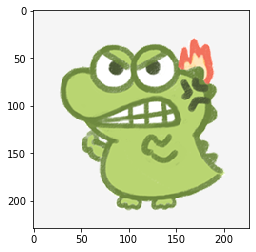

In [106]:
path="../../img/4.png"
img=show_img(path)
img_array=np.array(img)
print(img_array.shape) # 这里要注意，如果要使用，应该把轴的位置改一下，应该是(c_i,n_h,n_w)

K=torch.tensor([[[0,1],[1,2]],
                [[2,3],[3,4]],
                [[0,1],[1,2]]
               ])
X=torch.tensor(img_array[:,:,:3].reshape(3,img_array.shape[0],img_array.shape[1]))
print(f"输入X的形状为：{X.shape}")

**先尝试都是用d2l自定义的函数**,全部使用d2l的函数或者全部使用pytorch的函数，但是不能混着使用。

## d2l

### 原图的卷积结果

In [123]:
def corr2d_multi_in(X,K):
    """
    多输入二维卷积的计算实现
    X 表示3d的输入（每次拿出一个通道的矩阵来）
    K 表示3d的卷积核(每次拿出一个卷积核来)
    """
    return sum(d2l.corr2d(x,k) for x,k in zip(X,K))

convolution_rs=corr2d_multi_in(X,K)
convolution_rs.shape
print(f"原图的大小，{img_array.shape},卷积后图像的大小:{convolution_rs.shape}")

原图的大小，(229, 227, 4),卷积后图像的大小:torch.Size([228, 226])


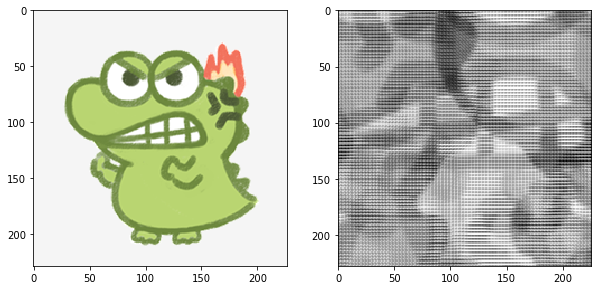

In [126]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(convolution_rs,cmap="gray")

在没有填充和步幅的情况下，
+ 输入维度是 (474, 474, 3)，输出维度是 (473, 473)
+ 这里输出通道直接就是1.由于多输入卷积里直接融合了，所以这里应该是没法完成池化操作。但是可以看看卷积的结果
+ 所以如果想卷积后再池化，应该需要使用多输出通道来做
+ 参考：[直方图-绘制子图subplot imshow](https://blog.csdn.net/sundanping_123/article/details/86543206)

### 图像平移

 这里BGR到RGB图像显示，参考[OpenCV与Python之图像的读入与显示以及利用Numpy的图像转换
](https://www.cnblogs.com/visionfeng/p/6094423.html)
+ 但是使用`Z[:,:,::-1]`会报错  `step must be greater than zero`

参考：[Numpy / OpenCV image BGR to RGB](https://zhuanlan.zhihu.com/p/129006120)
+ 改用：Z[:,:,[2,0,1]] 

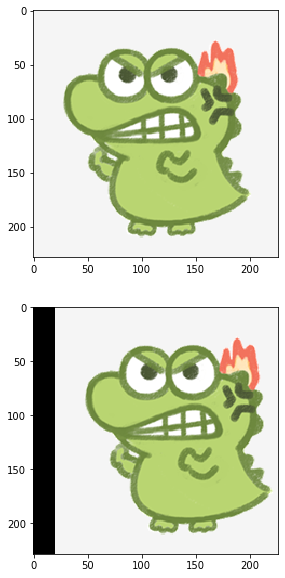

In [153]:
import cv2
import numpy as np

def move_right(path):
    image = cv2.imread(path)
    M = np.float32([[1, 0, 20], [0, 1, 0]]) 
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
#     plt.imshow(shifted[:,:,[2,1,0]])
    return shifted[:,:,[2,1,0]]

Z=move_right(path)
plt.figure(figsize=(5,10))
plt.subplot(211)
plt.imshow(X.reshape(229,227,3))
plt.subplot(212)
plt.imshow(Z.reshape(229,227,3))

In [146]:
Z.shape

(229, 227, 3)

torch.Size([3, 229, 227]) torch.Size([3, 229, 227])


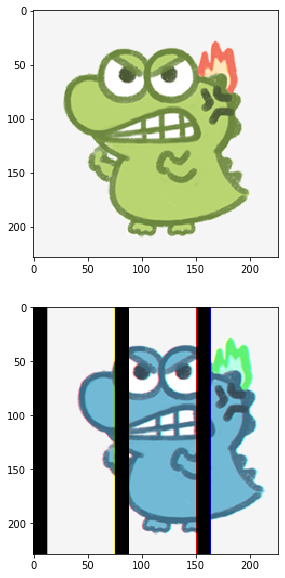

In [117]:
Z=torch.zeros_like(X)  # X.shape= (229, 227, 3)
print(Z.shape,X.shape)
Z[:,:,40:]=X[:,:,:187]
# plt.imshow(Z.reshape(229,227,3)[:,:,[2,1,0]])

plt.figure(figsize=(5,10))
plt.subplot(211)
plt.imshow(X.reshape(229,227,3))
plt.subplot(212)
plt.imshow(Z.reshape(229,227,3))

+ 至今也不明白，为什么直接移动像素会出错，必须使用乘法的这种方式。
+ 其实可以看出来，确实是移动了，但是多了两条竖线，而且整体背景颜色也改变了

### 对移位后的图像做卷积

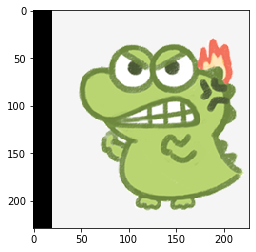

In [121]:
shifted_img=move_right(path)

**注意**

这里有个问题就很好玩，
+ 展示图像的时候，matplotlib和opencv都是(长，宽，channel)，
+ 但是在送入卷积核计算的时候，是(channel,长，宽)，刚好就需要reshape。。。

In [157]:
def show_compare(path):
    img = cv2.imread(path)
    if img.shape[2]!=3:
        image=img[:,:,:3].reshape(3,img.shape[0],img.shape[1])
    else:
        image=img.reshape(3,img.shape[0],img.shape[1])    
    image_tensor=torch.tensor(image)
    print(f"原图reshape（channel放到最后一位）转为tensor的维度为：{image_tensor.shape}")
    
    no_move=corr2d_multi_in(image_tensor,K)
    # 这个没有channel，因为只是多输入，结果只有一个channel，所以不担心channel这个维度的位置
    print(f"原图卷积后的维度为：{no_move.shape}")
    
    # 其实读取了两次图像，虽然有点浪费
    move_img=move_right(path)
    move_tensor=torch.tensor(move_img).reshape(3, move_img.shape[0],move_img.shape[1])
    print(f"平移后图像tensor进行reshape之后的维度：{move_tensor.shape}")
    move_rs=corr2d_multi_in(move_tensor,K)
    
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.imshow(img[:,:,[2,1,0]])
    plt.title("原图")
    
    plt.subplot(222)
    plt.imshow(no_move,cmap="gray")
    plt.title("原图卷积后")
    
    plt.subplot(223)
    plt.imshow(move_img)
    plt.title("原图向右平移")
    
    plt.subplot(224)
    plt.imshow(move_rs,cmap="gray")
    plt.title("原图向右平移后卷积")
    
    return (img,no_move,move_img,move_rs)

原图reshape（channel放到最后一位）转为tensor的维度为：torch.Size([3, 229, 227])
原图卷积后的维度为：torch.Size([228, 226])
平移后图像tensor进行reshape之后的维度：torch.Size([3, 229, 227])


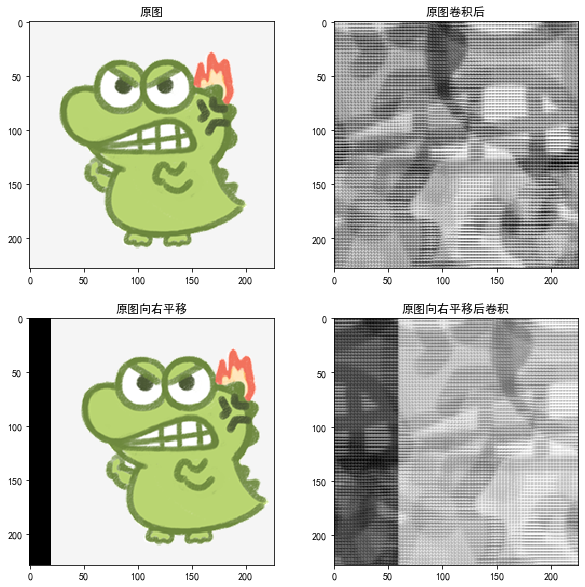

In [158]:
(img,img_convol,move_img,move_convol)=show_compare(path)

# 使用pytorch观察

### 不移动时候的卷积结果

In [159]:
img = cv2.imread(path)
img.shape

(229, 227, 3)

In [190]:
input_data=torch.tensor(img.reshape(1,3,229,227),dtype=torch.float32)
input_data.shape

torch.Size([1, 3, 229, 227])

这部分参考：
+ [2D 3D 多通道卷积及pytorch实现](https://blog.csdn.net/myyzqt/article/details/120722919)
+ pytorch中kernel个数不需要指定，会自动根据输入通道和输出通道的数量进行计算，只需要给定kernel_size即可

In [197]:
K=torch.tensor([[[[0,1],[1,2]],
                [[2,3],[3,4]],
                [[0,1],[1,2]]]],dtype=torch.float32)
K.shape

torch.Size([1, 3, 2, 2])

In [198]:
conv2d1=nn.Conv2d(3,1,kernel_size=2,stride=1, padding=0)
conv2d1.weight.data=K

In [199]:
conv_rs=conv2d1(input_data)

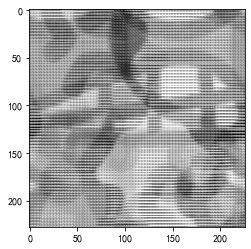

In [212]:
torch.squeeze(conv_rs).shape
plt.imshow(torch.squeeze(conv_rs).detach().numpy(),cmap=('gray'))

### 移动后的卷积以及卷积后加池化结果

(229, 227, 3)


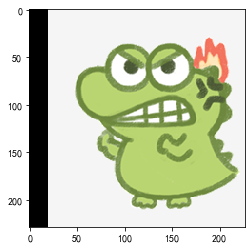

In [214]:
shifted_img=move_right(path)
plt.imshow(shifted_img)
print(shifted_img.shape)

C:\software\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


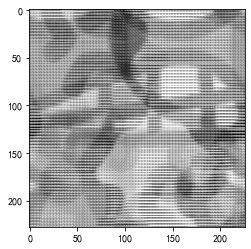

In [217]:
input_data=torch.tensor(input_data.reshape(1,3,229,227),dtype=torch.float32)

conv2d1=nn.Conv2d(3,1,kernel_size=2,stride=1, padding=0)
conv2d1.weight.data=K
conv_rs=conv2d1(input_data)
torch.squeeze(conv_rs).shape
plt.imshow(torch.squeeze(conv_rs).detach().numpy(),cmap=('gray'))

Text(0.5, 1.0, '平移后卷积再池化，池化3')

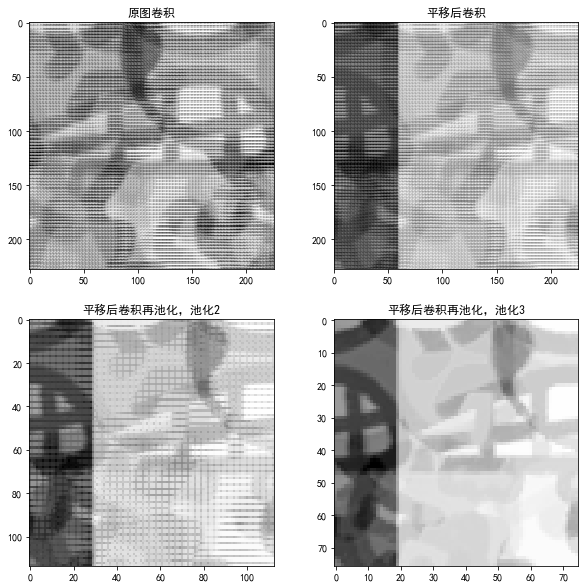

In [229]:
img_raw = cv2.imread(path)
shifted_img=move_right(path)


K=torch.tensor([[[[0,1],[1,2]],
                [[2,3],[3,4]],
                [[0,1],[1,2]]]],dtype=torch.float32)

def conv2d(img):
    conv2d1=nn.Conv2d(3,1,kernel_size=2,stride=1, padding=0)
    conv2d1.weight.data=K
    input_data=torch.tensor(img.reshape(1,3,229,227),dtype=torch.float32)
    conv_rs=conv2d1(input_data)
    plot_img_numpy=torch.squeeze(conv_rs).detach().numpy()
    return plot_img_numpy

def conv2d_pool(img,pool_size):
    input_data=torch.tensor(img.reshape(1,3,229,227),dtype=torch.float32)
    conv2d1=nn.Conv2d(3,1,kernel_size=2,stride=1, padding=0)
    conv2d1.weight.data=K
    
    pool1 = nn.MaxPool2d(pool_size,pool_size)  # 只是一个2*2的padding，但是图像偏移有20。。。
    
    conv_rs=conv2d1(input_data)
    pool_rs=pool1(conv_rs)
    
    plot_img_numpy=torch.squeeze(pool_rs).detach().numpy()
    return plot_img_numpy


img_raw_conv2d=conv2d(img_raw)
shifted_img_conv2d=conv2d(shifted_img)
conv2d_pool_3=conv2d_pool(shifted_img,3)
conv2d_pool_2=conv2d_pool(shifted_img,2)

figure=plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img_raw_conv2d,cmap=('gray'))
plt.title("原图卷积")

plt.subplot(222)
plt.imshow(shifted_img_conv2d,cmap=('gray'))
plt.title("平移后卷积")


plt.subplot(223)
plt.imshow(conv2d_pool_2,cmap=('gray'))
plt.title("平移后卷积再池化，池化2")

plt.subplot(224)
plt.imshow(conv2d_pool_3,cmap=('gray'))
plt.title("平移后卷积再池化，池化3")

In [222]:
img_raw.shape,img_raw_conv2d.shape

((229, 227, 3), (228, 226))